# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
import re
import string
from nltk.corpus import stopwords  

from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [ ]:
real_data = pd.read_csv('/content/drive/MyDrive/FakeNews/True.csv')
fake_data = pd.read_csv('/content/drive/MyDrive/FakeNews/Fake.csv')

In [ ]:
real_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
fake_data.shape, real_data.shape

((23481, 4), (21417, 4))

In [ ]:
#reducing dataset
real_data = real_data.iloc[:10000]
fake_data = fake_data.iloc[:10000]

In [ ]:
fake_data.shape, real_data.shape

((10000, 4), (10000, 4))

In [ ]:
#add new column for true and false news for later classification
real_data['target'] = 1
fake_data['target'] = 0

In [ ]:
#Merge both datasets
data = pd.concat([real_data, fake_data], ignore_index=True, sort=False)
data.shape

(20000, 5)

In [ ]:
data.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


# Data Cleaning

In [ ]:
#remove url and html
def remove_url(text):
  url = re.compile(r"https?://\S+|www\.\S+")
  return url.sub(r"",text)

def remove_html(text):
  html = re.compile(r"<.*?>")
  return html.sub(r"",text)

In [ ]:
#removal of Punctuation Marks and Special Characters
def remove_punctuation(text):
  return re.sub('\[[^]]*\]', '', text)

def special_char(text):
  return re.sub("[^a-zA-Z]"," ",text)

In [ ]:
#remove stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
def remove_stop_words(text):
  text = text.lower()
  text = nltk.word_tokenize(text)
  text = [word for word in text if not word in set(stopwords.words("english"))]
  return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#lemmatization
def lemmatize_word(text):
  lemma = nltk.WordNetLemmatizer()
  text = " ".join([lemma.lemmatize(word) for word in text])
  return text

In [ ]:
#now applying all the function
data["text"] = data["text"].apply(lambda x: remove_url(x))
data["text"] = data["text"].apply(lambda x: remove_html(x))
data["text"] = data["text"].apply(lambda x: remove_punctuation(x))
data["text"] = data["text"].apply(lambda x: special_char(x))
data["text"] = data["text"].apply(lambda x: remove_stop_words(x))
data["text"] = data["text"].apply(lambda x: lemmatize_word(x))

# Modeling

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data["text"], data['target'], test_size = 0.2, random_state = 0)

In [ ]:
x_train.shape, y_train.shape

((16000,), (16000,))

In [ ]:
#keep all rows to 300, padding news with less than 300, and truncating long ones
vocabulary_size = 100000
max_word_length = 500

In [ ]:
tokenizer = text.Tokenizer(num_words = vocabulary_size)
tokenizer.fit_on_texts(x_train)
tokenizer_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenizer_train, maxlen = max_word_length)

In [ ]:
tokenizer_test = tokenizer.texts_to_sequences(x_test)
x_test = sequence.pad_sequences(tokenizer_test, maxlen = max_word_length)

In [ ]:
x_train.shape, y_train.shape

((16000, 500), (16000,))

## Training LSTM Model

In [ ]:
batch_size = 256
epochs = 10
embed_size = 100

In [ ]:
model = Sequential()

model.add(Embedding(vocabulary_size, embed_size, input_length = max_word_length, trainable = False))

model.add(LSTM(units = 128, return_sequences = True, recurrent_dropout = 0.25, dropout = 0.25))
model.add(LSTM(units = 64, recurrent_dropout = 0.1, dropout = 0.1))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model.compile(optimizer = keras.optimizers.Adam(lr=0.01) ,  loss = 'binary_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 100)          10000000  
_________________________________________________________________
lstm_4 (LSTM)                (None, 500, 128)          117248    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 10,168,769
Trainable params: 168,769
Non-trainable params: 10,000,000
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, validation_split = 0.3, epochs = 5, batch_size = batch_size, shuffle = True, verbose = 1)

Epoch 1/5
44/44 [==============================] - 312s 7s/step - loss: 0.5365 - accuracy: 0.7294 - val_loss: 0.1907 - val_accuracy: 0.9390
Epoch 2/5
44/44 [==============================] - 303s 7s/step - loss: 0.1791 - accuracy: 0.9447 - val_loss: 0.1813 - val_accuracy: 0.9413
Epoch 3/5
44/44 [==============================] - 303s 7s/step - loss: 0.1995 - accuracy: 0.9366 - val_loss: 0.1833 - val_accuracy: 0.9423
Epoch 4/5
44/44 [==============================] - 303s 7s/step - loss: 0.1635 - accuracy: 0.9496 - val_loss: 0.1773 - val_accuracy: 0.9410
Epoch 5/5
44/44 [==============================] - 303s 7s/step - loss: 0.1504 - accuracy: 0.9520 - val_loss: 0.1427 - val_accuracy: 0.9492


## Testing

In [ ]:
model.evaluate(x_test, y_test)[1]*100

125/125 [==============================] - 26s 208ms/step - loss: 0.1404 - accuracy: 0.9515


95.14999985694885

In [ ]:
from collections import Counter
data['temp_list']=data['text'].apply(lambda x: str(x).split())
top=Counter([word for li in data['temp_list'] for word in li])
temp_1=pd.DataFrame(top.most_common(20))
temp_1.columns=["most_common_words","frequency"]
temp_1.style.background_gradient(cmap='Blues')

,most_common_words,frequency
0,trump,101231
1,said,61939
2,u,37341
3,president,31922
4,republican,31469
5,would,30302
6,state,29479
7,people,21260
8,donald,20679
9,one,19238


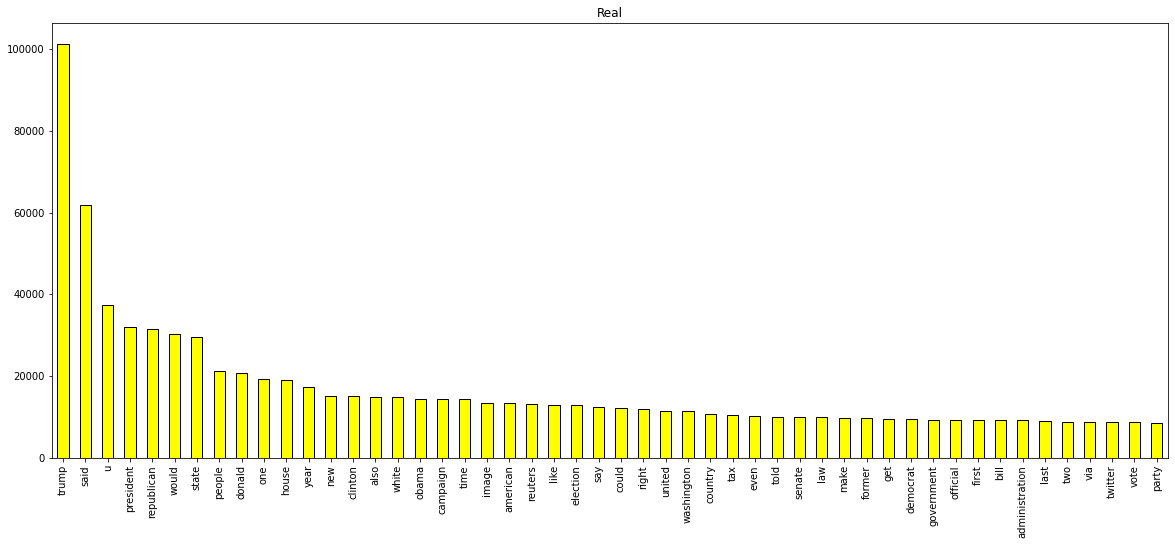

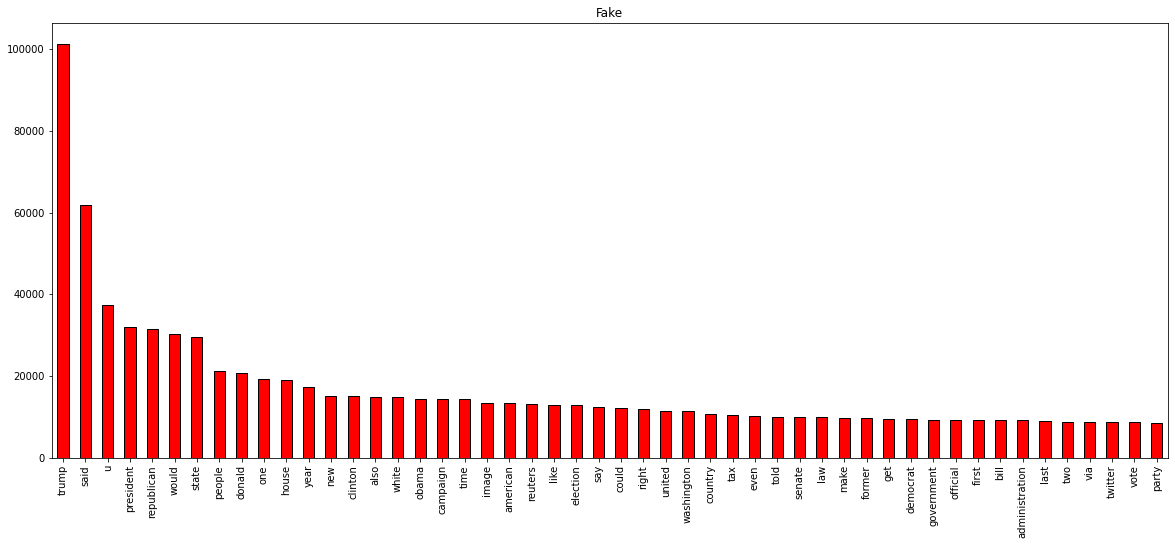

In [ ]:
# data_1=data[data['target']==1]
# pd.Series(' '.join([i for i in data.text]).split()).value_counts()[:50].plot(kind='bar',figsize=(20,8),color='yellow'
#                                                                                        ,edgecolor='black',title='Real')
# plt.show()

# data_1=data[data['target']==0]
# pd.Series(' '.join([i for i in data.text]).split()).value_counts()[:50].plot(kind='bar',figsize=(20,8),color='red'
#                                                                                        ,edgecolor='black',title='Fake')
# plt.show()